In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os.path

from os import getcwd
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import savemat, loadmat
import math
from scipy.fftpack import fft, ifft
from scipy.stats import zscore, f_oneway
#import samplerate
import multiprocessing as mp
from scipy.signal import resample
import random
import pyreadr
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import NMF
import scipy.cluster.hierarchy as hac 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import plotly.express as px

In [2]:
def zscore_bseline(input_mat):
    use_unit_z = np.zeros(input_mat.shape)
    for item in range(input_mat.shape[0]):
        use_unit = input_mat[item]
        unit_baseline = use_unit[0:1500]
        unit_baseline_mean = np.mean(unit_baseline)
        unit_baseline_std = np.std(unit_baseline)
        use_unit_z[item] = (use_unit - unit_baseline_mean)/unit_baseline_std
    return use_unit_z

In [3]:
all_hg_ave_activity = loadmat("processed_data/all_cue_ecog.mat")
ecog_hg_onset_mean = all_hg_ave_activity['ecog_hg_onset_mean']
ecog_hg_onset_sem = all_hg_ave_activity['ecog_hg_onset_sem']
ecog_hg_sus_mean = all_hg_ave_activity['ecog_hg_sus_mean']
ecog_hg_sus_sem = all_hg_ave_activity['ecog_hg_sus_sem']
ecog_hg_three_mean = all_hg_ave_activity['ecog_hg_three_mean']
ecog_hg_three_sem = all_hg_ave_activity['ecog_hg_three_sem']

In [4]:
ecog_hg_mean = np.concatenate((ecog_hg_onset_mean, ecog_hg_sus_mean, ecog_hg_three_mean))
ecog_hg_mean.shape

ecog_hg_mean_z = zscore_bseline(ecog_hg_mean)

ecog_hg_good = np.delete(ecog_hg_mean_z, np.where((ecog_hg_mean_z[:, :1500] >= 5))[0], axis=0)
ecog_hg_good = ecog_hg_good - ecog_hg_good.min()


(220, 5000)

In [5]:
use_cmap = sns.choose_colorbrewer_palette('diverging')

interactive(children=(Dropdown(description='name', options=('RdBu', 'RdGy', 'PRGn', 'PiYG', 'BrBG', 'RdYlBu', …

NameError: name 'use_cmap' is not defined

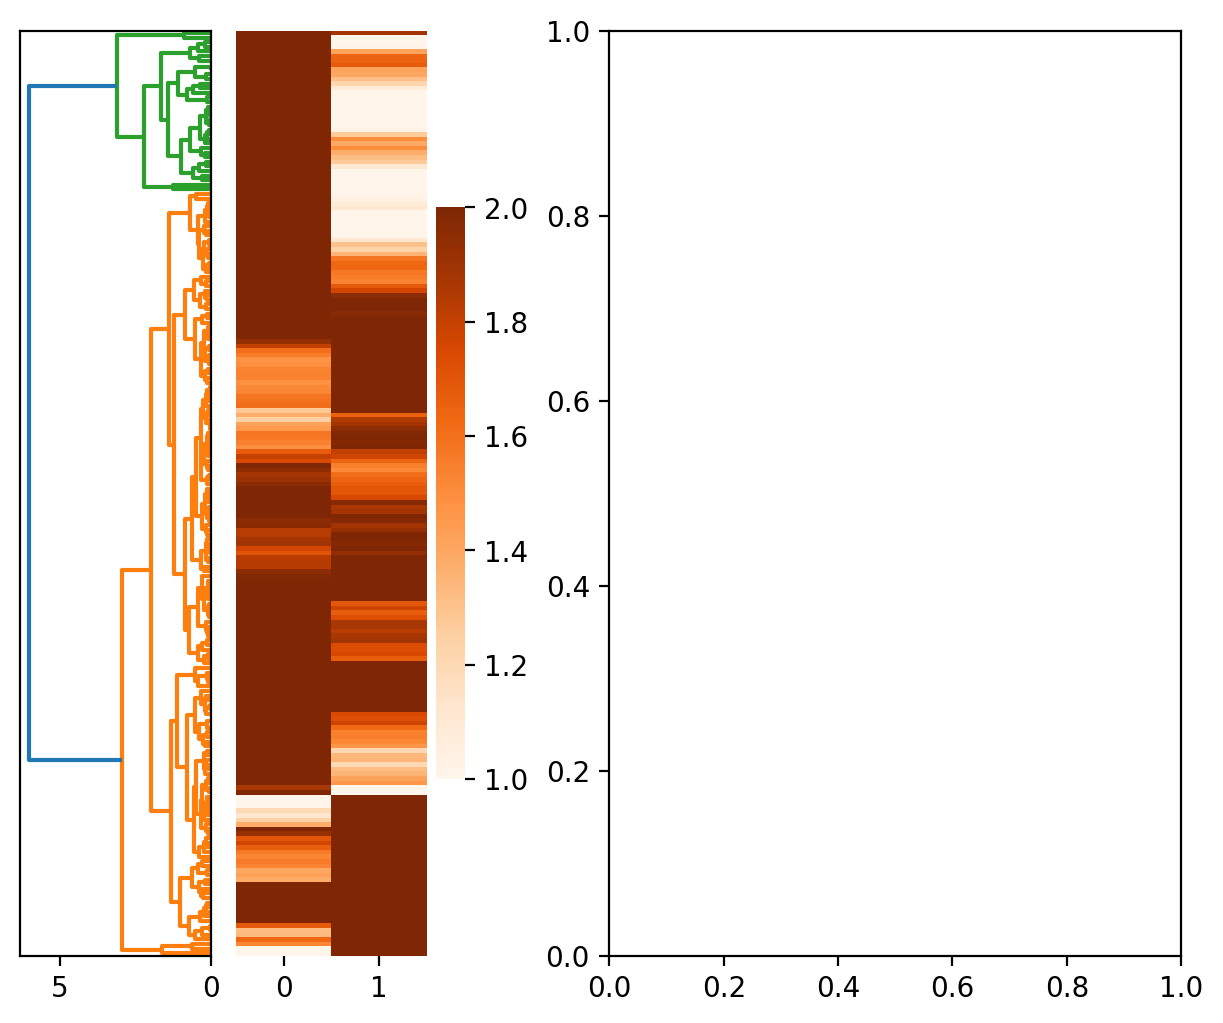

In [5]:
fig, axs = plt.subplots(1, 3, constrained_layout=True, 
                               figsize=(6, 5), dpi=200, 
                               gridspec_kw={'width_ratios': [1, 1, 3]})

NMF_input = ecog_hg_good[:, 1000:3000]
NMF_input = NMF_input - NMF_input.min()
model = NMF(n_components=2, init='random', 
            random_state=0, solver='mu', 
            beta_loss='frobenius', tol=0.0000001, 
            max_iter=250, alpha_W=0.01)
NMF_output = model.fit_transform(NMF_input)

Z = hac.linkage(NMF_output, 
                metric='euclidean', optimal_ordering=1, 
                method='weighted')
'''dn = hac.dendrogram(Z, get_leaves=1, ax=axs[0], 
                    orientation='left', no_labels=1, 
                    distance_sort=1, color_threshold=3, 
                    above_threshold_color="grey")'''

dn = hac.dendrogram(Z, get_leaves=1, ax=axs[0], 
                    orientation='left', no_labels=1, 
                    distance_sort=0)


NMF_reordere = np.zeros(NMF_output.shape)
for item in range(NMF_output.shape[0]):
    NMF_reordere[item] = NMF_output[dn['leaves'][item]]

sns.heatmap(NMF_reordere, ax=axs[1], 
            vmax=2, vmin=1, cmap='Oranges', 
            yticklabels=False) #

cos_ordered_units = np.zeros(ecog_hg_good.shape)
for item in range(ecog_hg_good.shape[0]):
    cos_ordered_units[item] = ecog_hg_good[dn['leaves'][item]]

sns.heatmap(zscore_bseline(cos_ordered_units)[:, 1000:3000], 
            cmap=use_cmap, cbar=False, 
            vmax=6, vmin=-3, ax=axs[2], 
            yticklabels=False, xticklabels=500)

plt.show();

In [6]:
all_unit_ave_activity = loadmat("processed_data/all_unit_ave_activity.mat")
cue_mat_1 = all_unit_ave_activity['cue_mat_1']
cue_mat_all = all_unit_ave_activity['cue_mat_all']
cue_mat_1_sem = all_unit_ave_activity['cue_mat_1_sem']
cue_mat_all_sem = all_unit_ave_activity['cue_mat_all_sem']

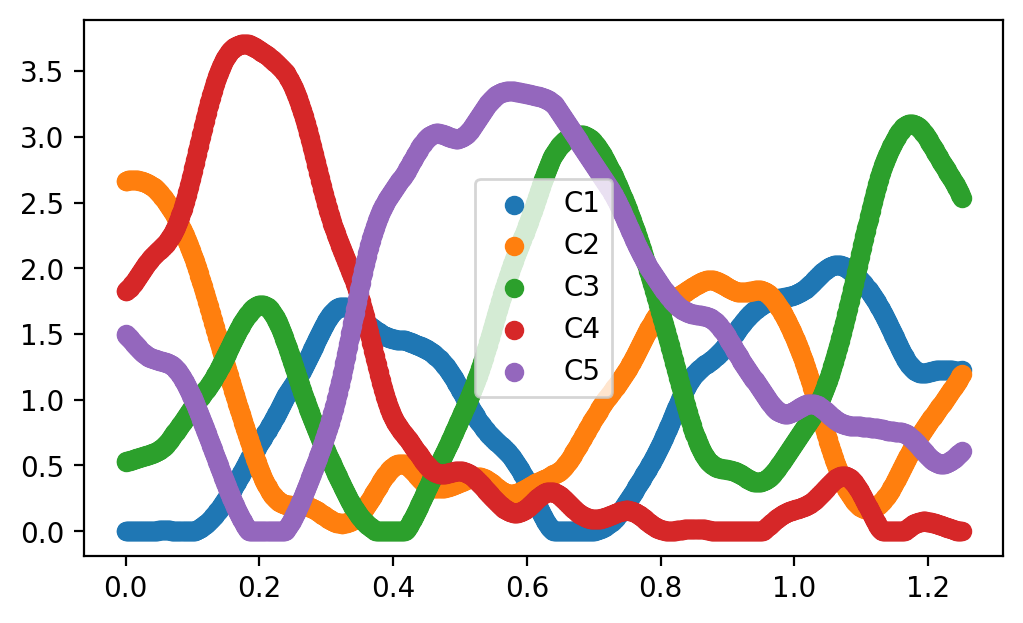

In [18]:
NMF_input = zscore_bseline(cue_mat_1)[:, 1500:2750]
NMF_input = NMF_input - NMF_input.min()

model = NMF(n_components=5, init='random', random_state=0)
NMF_model_auditory = model.fit(NMF_input)


fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(5, 3), dpi=200)
axs.patch.set_alpha(0)
fig.patch.set_alpha(0)

x_lab = np.linspace(0, 1.25, 1250)

plt.scatter(x=x_lab, y=NMF_model_auditory.components_[0], label='C1')
plt.scatter(x=x_lab, y=NMF_model_auditory.components_[1], label='C2')
plt.scatter(x=x_lab, y=NMF_model_auditory.components_[2], label='C3')
plt.scatter(x=x_lab, y=NMF_model_auditory.components_[3], label='C4')
plt.scatter(x=x_lab, y=NMF_model_auditory.components_[4], label='C5')

plt.legend()
plt.show();

In [13]:
cue_mat_1.shape

(205, 5000)

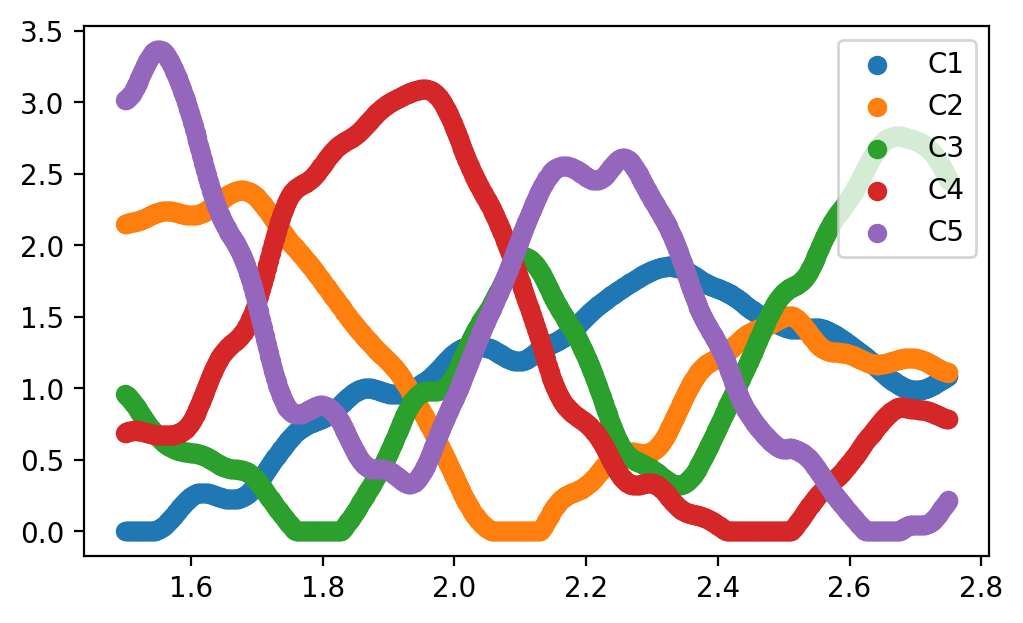

In [22]:
NMF_input = zscore_bseline(cue_mat_1)[:, 3000:-750]
NMF_input = NMF_input - NMF_input.min()

model = NMF(n_components=5, init='random', random_state=0)
NMF_model_speech = model.fit(NMF_input)


fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(5, 3), dpi=200)
axs.patch.set_alpha(0)
fig.patch.set_alpha(0)

x_lab = np.linspace(1.5, 2.75, 1250)

plt.scatter(x=x_lab, y=NMF_model_speech.components_[0], label='C1')
plt.scatter(x=x_lab, y=NMF_model_speech.components_[1], label='C2')
plt.scatter(x=x_lab, y=NMF_model_speech.components_[2], label='C3')
plt.scatter(x=x_lab, y=NMF_model_speech.components_[3], label='C4')
plt.scatter(x=x_lab, y=NMF_model_speech.components_[4], label='C5')

plt.legend()
plt.show();

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import linear_sum_assignment


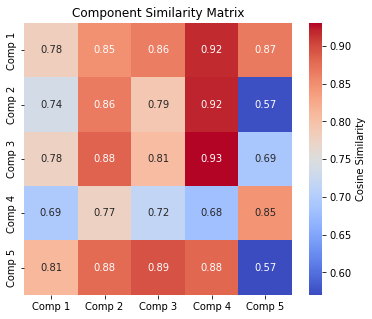

In [20]:
# Example data: two matrices of 5 components over time
# Each matrix has shape (time_points, 5), assuming 10 time points
matrix_1 = np.random.rand(10, 5)
matrix_2 = np.random.rand(10, 5)

# Compute the cosine similarity between the components of the two matrices
# Transpose the matrices so that the cosine similarity is calculated between columns (components)
similarity_matrix = cosine_similarity(matrix_1.T, matrix_2.T)

# Plot the similarity matrix as a heatmap
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(similarity_matrix, annot=True, cmap="coolwarm", ax=ax, 
            xticklabels=[f"Comp {i+1}" for i in range(5)], 
            yticklabels=[f"Comp {i+1}" for i in range(5)], 
            cbar_kws={'label': 'Cosine Similarity'})

ax.set_title("Component Similarity Matrix")
plt.show();

In [14]:
matrix_1.shape
matrix_2.shape

(2000, 5)

(2000, 5)

In [ ]:
cosine_similarity()

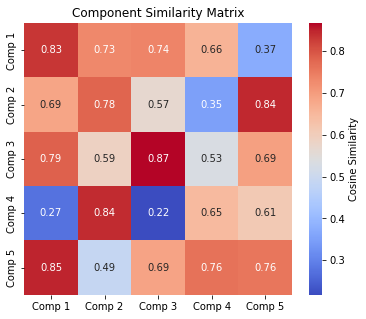

In [25]:
# Example data: two matrices of 5 components over time
# Each matrix has shape (time_points, 5), assuming 10 time points
matrix_1 = NMF_model_auditory.components_.T
matrix_2 = NMF_model_speech.components_.T

# Compute the cosine similarity between the components of the two matrices
# Transpose the matrices so that the cosine similarity is calculated between columns (components)
similarity_matrix = cosine_similarity(matrix_1.T, matrix_2.T)

# Plot the similarity matrix as a heatmap
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(similarity_matrix, annot=True, cmap="coolwarm", ax=ax, 
            xticklabels=[f"Comp {i+1}" for i in range(5)], 
            yticklabels=[f"Comp {i+1}" for i in range(5)], 
            cbar_kws={'label': 'Cosine Similarity'})

ax.set_title("Component Similarity Matrix")
plt.show();

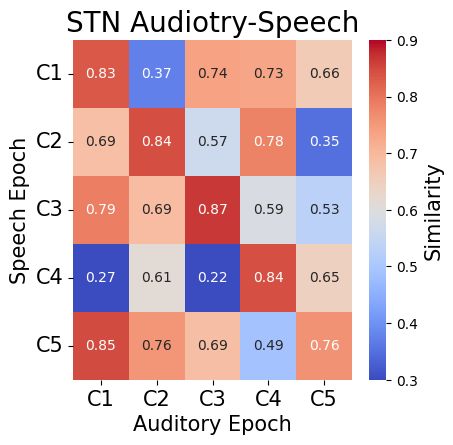

In [33]:
# Example data: two matrices of 5 components over time
# Each matrix has shape (time_points, 5), assuming 10 time points
matrix_1 = NMF_model_auditory.components_.T
matrix_2 = NMF_model_speech.components_.T

# Compute the cosine similarity between the components of the two matrices
# Transpose the matrices so that the cosine similarity is calculated between columns (components)
similarity_matrix = cosine_similarity(matrix_1.T, matrix_2.T)


# Use the Hungarian algorithm to find the optimal reordering of the second matrix
row_ind, col_ind = linear_sum_assignment(-similarity_matrix)  # Maximize similarity, so negate the matrix

# Reorder the second matrix based on the Hungarian algorithm result
reordered_similarity_matrix = similarity_matrix[:, col_ind]


# Plot the similarity matrix as a heatmap
fig, ax = plt.subplots(figsize=(4.5, 4.5), dpi=100)
g = sns.heatmap(reordered_similarity_matrix, annot=True, cmap='coolwarm', ax=ax, 
            xticklabels=[f"C{i+1}" for i in range(5)], 
            yticklabels=[f"C{i+1}" for i in range(5)], 
            cbar_kws={'label': 'Similarity'}, vmax=0.9, vmin=0.3)
g.tick_params(axis='both', labelsize=15)
ax.figure.axes[-1].yaxis.label.set_size(15)
ax.tick_params(axis='y', rotation=0)

ax.set_title("STN Audiotry-Speech", fontsize=20)
ax.set_xlabel('Auditory Epoch', fontsize=15)
ax.set_ylabel('Speech Epoch', fontsize=15)

plt.show();

In [34]:
from scipy.stats import pearsonr

def pearson_similarity_matrix(matrix_1, matrix_2):
    n_components = matrix_1.shape[1]
    similarity_matrix = np.zeros((n_components, n_components))
    
    for i in range(n_components):
        for j in range(n_components):
            similarity_matrix[i, j], _ = pearsonr(matrix_1[:, i], matrix_2[:, j])
    
    return similarity_matrix


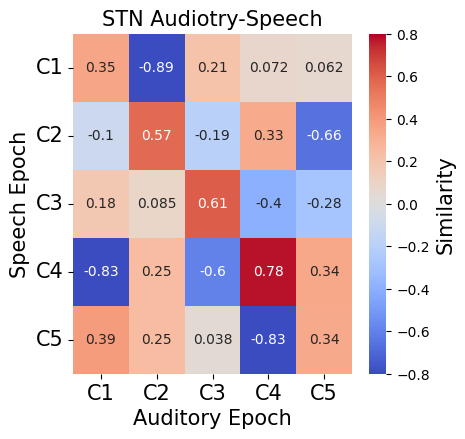

In [51]:
# Example data: two matrices of 5 components over time
# Each matrix has shape (time_points, 5), assuming 10 time points
matrix_1 = NMF_model_auditory.components_.T
matrix_2 = NMF_model_speech.components_.T

# Compute the cosine similarity between the components of the two matrices
# Transpose the matrices so that the cosine similarity is calculated between columns (components)
similarity_matrix = pearson_similarity_matrix(matrix_1, matrix_2)


# Use the Hungarian algorithm to find the optimal reordering of the second matrix
row_ind, col_ind = linear_sum_assignment(-similarity_matrix)  # Maximize similarity, so negate the matrix

# Reorder the second matrix based on the Hungarian algorithm result
reordered_similarity_matrix = similarity_matrix[:, col_ind]


# Plot the similarity matrix as a heatmap
fig, ax = plt.subplots(figsize=(4.5, 4.5), dpi=100)
g = sns.heatmap(reordered_similarity_matrix, annot=True, cmap='coolwarm', ax=ax, 
            xticklabels=[f"C{i+1}" for i in range(5)], 
            yticklabels=[f"C{i+1}" for i in range(5)], 
            cbar_kws={'label': 'Similarity'}, vmax=0.8, vmin=-0.8)
g.tick_params(axis='both', labelsize=15)
ax.figure.axes[-1].yaxis.label.set_size(15)
ax.tick_params(axis='y', rotation=0)

ax.set_title("STN Audiotry-Speech", fontsize=15)
ax.set_xlabel('Auditory Epoch', fontsize=15)
ax.set_ylabel('Speech Epoch', fontsize=15)

plt.show();

In [79]:
n_comp=4

In [107]:
NMF_input = zscore_bseline(cue_mat_1)[:, 1500:3000]
NMF_input = NMF_input - NMF_input.min()

model = NMF(n_components=4, init='warn', random_state=0)
NMF_model_auditory = model.fit(NMF_input)

In [108]:
NMF_input = zscore_bseline(cue_mat_1)[:, 3000:-500]
NMF_input = NMF_input - NMF_input.min()

model = NMF(n_components=4, init='warn', random_state=0)
NMF_model_speech = model.fit(NMF_input)

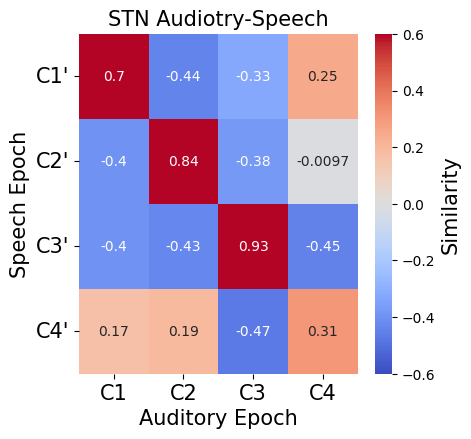

In [109]:
matrix_1 = NMF_model_auditory.components_.T
matrix_2 = NMF_model_speech.components_.T

similarity_matrix = pearson_similarity_matrix(matrix_1, matrix_2)
row_ind, col_ind = linear_sum_assignment(-similarity_matrix)  # Maximize similarity, so negate the matrix
reordered_similarity_matrix = similarity_matrix[:, col_ind]

fig, ax = plt.subplots(figsize=(4.5, 4.5), dpi=100)
g = sns.heatmap(reordered_similarity_matrix, annot=True, cmap='coolwarm', ax=ax, 
            xticklabels=[f"C{i+1}" for i in range(reordered_similarity_matrix.shape[0])], 
            yticklabels=[f"C{i+1}'" for i in range(reordered_similarity_matrix.shape[0])], 
            cbar_kws={'label': 'Similarity'}, vmax=0.6, vmin=-0.6)
g.tick_params(axis='both', labelsize=15)
ax.figure.axes[-1].yaxis.label.set_size(15)
ax.tick_params(axis='y', rotation=0)

ax.set_title("STN Audiotry-Speech", fontsize=15)
ax.set_xlabel('Auditory Epoch', fontsize=15)
ax.set_ylabel('Speech Epoch', fontsize=15)

plt.show();

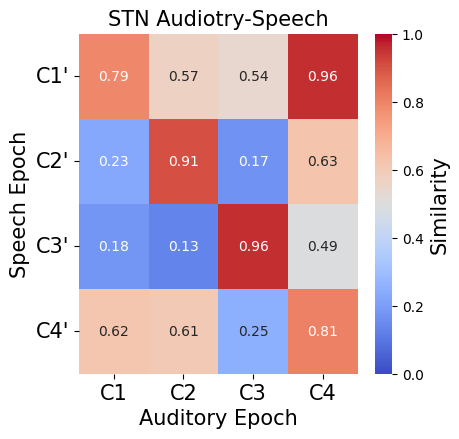

In [110]:
matrix_1 = NMF_model_auditory.components_
matrix_2 = NMF_model_speech.components_

similarity_matrix = cosine_similarity(matrix_1, matrix_2)
row_ind, col_ind = linear_sum_assignment(-similarity_matrix)  # Maximize similarity, so negate the matrix
reordered_similarity_matrix = similarity_matrix[:, col_ind]

fig, ax = plt.subplots(figsize=(4.5, 4.5), dpi=100)
g = sns.heatmap(reordered_similarity_matrix, annot=True, cmap='coolwarm', ax=ax, 
            xticklabels=[f"C{i+1}" for i in range(reordered_similarity_matrix.shape[0])], 
            yticklabels=[f"C{i+1}'" for i in range(reordered_similarity_matrix.shape[0])], 
            cbar_kws={'label': 'Similarity'}, vmax=1, vmin=0)
g.tick_params(axis='both', labelsize=15)
ax.figure.axes[-1].yaxis.label.set_size(15)
ax.tick_params(axis='y', rotation=0)

ax.set_title("STN Audiotry-Speech", fontsize=15)
ax.set_xlabel('Auditory Epoch', fontsize=15)
ax.set_ylabel('Speech Epoch', fontsize=15)

plt.show();

In [93]:
NMF_input = zscore_bseline(cue_mat_1)[:, 1000:2750]
NMF_input = NMF_input - NMF_input.min()

model = NMF(n_components=n_comp, init='warn', 
            random_state=0, solver='mu', alpha=0.001, 
            beta_loss='frobenius', tol=0.0001, 
            max_iter=250, alpha_W=0.2, l1_ratio=1)
NMF_model_auditory = model.fit(NMF_input)

NMF_input = zscore_bseline(cue_mat_1)[:, 3250:]
NMF_input = NMF_input - NMF_input.min()

model = NMF(n_components=n_comp, init='warn', 
            random_state=0, solver='mu', alpha=0.001, 
            beta_loss='frobenius', tol=0.0001, 
            max_iter=250, alpha_W=0.2, l1_ratio=1)
NMF_model_speech = model.fit(NMF_input)

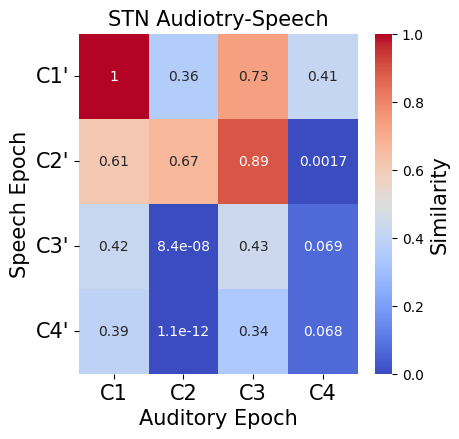

In [94]:
matrix_1 = NMF_model_auditory.components_
matrix_2 = NMF_model_speech.components_

similarity_matrix = cosine_similarity(matrix_1, matrix_2)
row_ind, col_ind = linear_sum_assignment(-similarity_matrix)  # Maximize similarity, so negate the matrix
reordered_similarity_matrix = similarity_matrix[:, col_ind]

fig, ax = plt.subplots(figsize=(4.5, 4.5), dpi=100)
g = sns.heatmap(reordered_similarity_matrix, annot=True, cmap='coolwarm', ax=ax, 
            xticklabels=[f"C{i+1}" for i in range(reordered_similarity_matrix.shape[0])], 
            yticklabels=[f"C{i+1}'" for i in range(reordered_similarity_matrix.shape[0])], 
            cbar_kws={'label': 'Similarity'}, vmax=1, vmin=0)
g.tick_params(axis='both', labelsize=15)
ax.figure.axes[-1].yaxis.label.set_size(15)
ax.tick_params(axis='y', rotation=0)

ax.set_title("STN Audiotry-Speech", fontsize=15)
ax.set_xlabel('Auditory Epoch', fontsize=15)
ax.set_ylabel('Speech Epoch', fontsize=15)

plt.show();